# [1D-BASELINE] Exp30: No Random Pan and Tilt Policy

## Import

In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

In [2]:
import pickle
import math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import copy
import random
import pandas as pd
from sklearn.metrics import mean_squared_error

In [3]:
import datetime
import time
from IPython.display import clear_output

In [4]:
from grace.system import Grace
from grace.capture import LeftEyeCapture, RightEyeCapture
from grace.utils import get_center_chessboard_point, get_chessboard_point, generate_triangle_wave
from aec.baseline import PanBacklash, TiltPolicy

## Initialization

In [5]:
# Instantiation
grace = Grace(degrees=True)
left_cam = LeftEyeCapture()

[ROS Client] ROS Connection Successful at http://BodyNC-NUC:9090


## Instantiation

In [6]:
# Baseline Policies

pan_backlash = PanBacklash()
tilt_policy = TiltPolicy()

In [7]:
# Experiment Helper Functions

def px_to_deg_fx(x):
    x = math.atan(x/569.4456315)  #LEFT: fx = 569.4456315. fy = 571.54490033
    x = math.degrees(x)
    return x

def px_to_deg_fy(x):
    x = math.atan(x/571.54490033)  #LEFT: fx = 569.4456315. fy = 571.54490033
    x = math.degrees(x)
    return x

def save_pickle_data(data, camera: str, name: str):
    # Making Directory
    filename = datetime.datetime.now().strftime("%Y%m%d_%H%M%S_%f") + "_" + camera + "_" + name
    filepath = os.path.join(os.path.abspath(".."), "const_results", filename)

    # Saving to Pickle File
    with open(filepath + ".pickle", 'wb') as file:
        pickle.dump(data, file)
    print('Data saved in:', filepath + ".pickle")
    return filepath + ".pickle"

def ctr_cross_img(img):
    img = cv.line(img, (315, 0), (315, 480), (0,255,0))
    img = cv.line(img, (0, 202), (640, 202), (0,255,0))
    img = cv.drawMarker(img, (315,202), color=(0, 255, 0), markerType=cv.MARKER_CROSS, markerSize=15, thickness=2)
    return img

def get_chess_target(idx, img):
    target = get_chessboard_point(img, idx)
    delta_x = target[0]-314.69441889
    delta_x_deg = px_to_deg_fx(delta_x)
    delta_y =  201.68845842 - target[1]
    delta_y_deg = px_to_deg_fy(delta_y)
    
    print("Delta x (px)=", delta_x)
    print("Delta x (deg)=", delta_x_deg)
    print("Delta y (px)=", delta_y)
    print("Delta y (deg)=", delta_y_deg)
    
    return delta_x, delta_y

def display_target(delta_x, delta_y, img):
    abs_x = 314.69441889 + delta_x
    abs_y = 201.68845842 - delta_y
    disp_img = cv.drawMarker(img, (round(abs_x),round(abs_y)), color=(255, 0, 0), markerType=cv.MARKER_TILTED_CROSS, markerSize=13, thickness=2)
    return disp_img

def approx_reset():
    state = grace.move_left_eye((None, 0))
    grace.slow_move_left_eye_pan(angle=8.0, step_size=0.0879, time_interval=0.015)
    grace.slow_move_left_eye_pan(angle=-8.0, step_size=0.0879, time_interval=0.015)
    grace.slow_move_left_eye_pan(angle=0, step_size=0.0879, time_interval=0.015)
    pan_backlash.phi = 0.4
    tilt_policy.phi = 0
    time.sleep(0.75)
    return state

In [8]:
pickle_data = {
    "title": "[1D-BASELINE] Exp30: NoRandPanTiltPolicy",
    "description": None,
    "data_label": ['0'],
    "data": None,
    "datetime": datetime.datetime.now().strftime("%Y%m%d_%H%M%S_%f")
}

data_list = []

In [9]:
# Center the left eye

state = approx_reset()
pixel_state = get_chessboard_point(left_cam.frame, 21)
print(state)
print(pixel_state)

(0.0, 0.0)
[318.16595458984375, 197.972412109375]


## Initial Check

In [10]:
# Initial Motor State

grace_state = grace.state

theta_p = grace_state[0]
phi_p = pan_backlash.phi
theta_t = grace_state[2]
phi_t = tilt_policy.phi

print("Current Pan Motor Position:", theta_p)
print("Current Pan Predicted Eye Position:", phi_p)
print("Current Tilt Motor Position:", theta_t)
print("Current Tilt Predicted Eye Position:", phi_t)

Current Pan Motor Position: 0.0
Current Pan Predicted Eye Position: 0.4
Current Tilt Motor Position: 0.0
Current Tilt Predicted Eye Position: 0


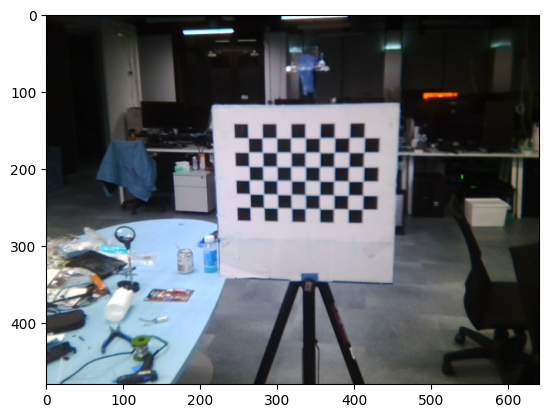

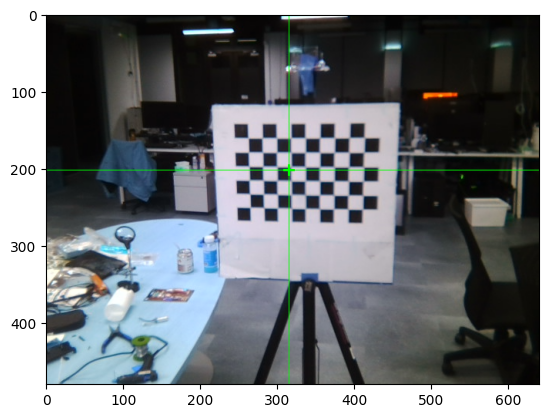

In [11]:
# Capture a frame

base_img = left_cam.frame
img = base_img.copy()
img = ctr_cross_img(img)

plt.imshow(base_img)
plt.show()
plt.imshow(img)

Delta x (px)= -32.368826848984384
Delta x (deg)= -3.253345831295792
Delta y (px)= -31.94679548625001
Delta y (deg)= -3.1992479555687567


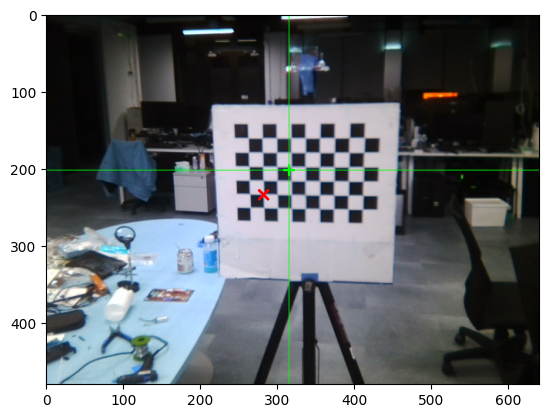

In [12]:
# Get a Chess Target

delta_x,delta_y = get_chess_target(idx=37, img=base_img)
disp_img = display_target(delta_x,delta_y,img)
plt.imshow(disp_img)

In [13]:
# No Baseline Policy


cmd_p = theta_p + px_to_deg_fx(delta_x)/1.6328
cmd_t = theta_t + px_to_deg_fy(delta_y)/0.3910

pos_p = 1.6328*cmd_p
pos_t = 0.3910*cmd_t

print('Pan Motor Command:', cmd_p)
print('Predicted Pan Eye Position:', pos_p)
print('Tilt Motor Command:', cmd_t)
print('Predicted Tilt Eye Position:', pos_t)

Pan Motor Command: -1.9924949971189319
Predicted Pan Eye Position: -3.253345831295792
Tilt Motor Command: -8.18221983521421
Predicted Tilt Eye Position: -3.1992479555687563


In [14]:
# Capture Command

state = grace.move_left_eye((cmd_p, cmd_t))
theta_p = state[0]
theta_t = state[1]
print(state)

(-2.021484375, -8.26171875)


Delta x (px)= -4.429892522812509
Delta x (deg)= -0.44571248126877805
Delta y (px)= -4.113741897382823
Delta y (deg)= -0.41238401139388453


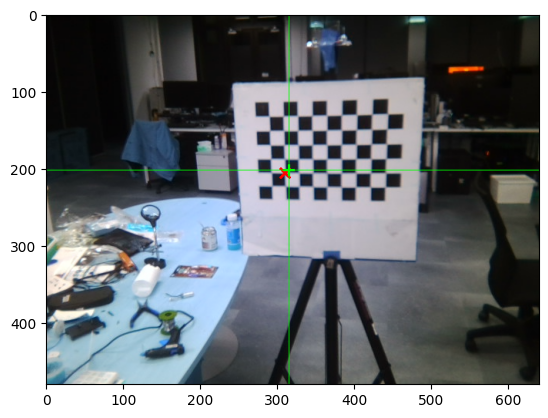

In [15]:
# Checking of Output

base_img = left_cam.frame
img = base_img.copy()
delta_x, delta_y = get_chess_target(idx=37, img=base_img)
disp_img = display_target(delta_x, delta_y, img)
disp_img = ctr_cross_img(disp_img)
plt.imshow(disp_img)

# Experiment

In [16]:
# Parameters

trials = 2700

In [17]:
# Approx Center the Left Eye

state = approx_reset()
pixel_state = get_chessboard_point(left_cam.frame, 21)
print(state)
print(pixel_state)

(-2.021484375, 0.0)
[318.4994201660156, 198.19329833984375]


In [18]:
# Experiment

data = {
    "chess_idx": [],
    "prev_base_img": [], 
    "prev_disp_img": [], 
    "prev_ctr_px":[],
    "prev_targ_px":[],
    "prev_theta_p": [],
    "prev_theta_t": [],
    "prev_model_phi_p": [],
    "prev_model_phi_t": [],
    "prev_delta_x": [],
    "prev_delta_y": [],
    "new_targ_px":[],
    "new_model_theta_p": [],
    "new_model_theta_t": [],
    "new_model_phi_p": [],
    "new_model_phi_t": [],
    "new_theta_p": [],
    "new_theta_t": [], 
    "new_ctr_px":[],
    "new_base_img": [],
    "new_delta_x": [],
    "new_delta_y": [],
    "new_disp_img": [],
}


old_delta_x_list = []
new_delta_x_list = []
old_delta_y_list = []
new_delta_y_list = []
theta_p_list = []
theta_t_list = []
phi_p_list = []
phi_t_list = []

for i in range(trials):
    
    clear_output(wait=True)
    
    idx = random.randrange(0,54)
    print('=======(target=%d,%d/%d)========' % (idx,i+1,trials))
    data["chess_idx"].append(idx)

    # Capture a frame
    base_img = left_cam.frame
    data["prev_base_img"].append(base_img)
    img = base_img.copy()
    
    # Get Previous Center Point
    pixel_state = get_chessboard_point(base_img, 3)
    data["prev_ctr_px"].append(pixel_state)

    # Motor State
    grace_state = grace.state
    theta_p = grace_state[0]
    phi_p = pan_backlash.phi
    theta_t = grace_state[2]
    phi_t = tilt_policy.phi
    
    data["prev_theta_p"].append(theta_p)
    data["prev_model_phi_p"].append(phi_p)
    data["prev_theta_t"].append(theta_t)
    data["prev_model_phi_t"].append(phi_t)
    
    # print("Current Pan Motor Position:", theta_p)
    # print("Current Pan Predicted Eye Position:", phi_p)
    # print("Current Tilt Motor Position:", theta_t)
    # print("Current Tilt Predicted Eye Position:", phi_t)

    # Get a Chess Target
    pixel_state = get_chessboard_point(base_img, idx)
    data["prev_targ_px"].append(pixel_state)
    delta_x, delta_y = get_chess_target(idx=idx, img=base_img)
    data["prev_delta_x"].append(delta_x)
    data["prev_delta_y"].append(delta_y)
    img = display_target(delta_x, delta_y,img)
    disp_img = ctr_cross_img(img)
    data["prev_disp_img"].append(disp_img)
    # cv.imshow("Display", disp_img)
    # cv.waitKey(0.5)

    # No Baseline Policy
    cmd_p = theta_p + px_to_deg_fx(delta_x)/1.6328
    cmd_t = theta_t + px_to_deg_fy(delta_y)/0.3910
    pos_p = 1.6328*cmd_p
    pos_t = 0.3910*cmd_t
    # cmd_p, pos_p = pan_backlash.calc_cmd(delta_x, theta=theta_p)
    # cmd_t, pos_t = tilt_policy.calc_cmd(delta_y, theta=theta_t)

    data["new_model_theta_p"].append(cmd_p)
    data["new_model_phi_p"].append(pos_p)
    data["new_model_theta_t"].append(cmd_t)
    data["new_model_phi_t"].append(pos_t)
    # print('Pan Motor Command:', cmd_p)
    # print('Predicted Pan Eye Position:', pos_p)
    # print('Tilt Motor Command:', cmd_t)
    # print('Predicted Tilt Eye Position:', pos_t)

    # Capture Command
    state = grace.move_left_eye((cmd_p, cmd_t))
    theta_p = state[0]
    theta_t = state[1]
    data["new_theta_p"].append(theta_p)
    data["new_theta_t"].append(theta_t)
    # print("Actual Pan Motor Command:", theta_p)
    # print("Actual Pan Motor Command:", theta_t)

    # Checking of Output
    base_img = left_cam.frame
    data["new_base_img"].append(base_img)
    img = base_img.copy()
    pixel_state = get_chessboard_point(base_img, idx)
    data["new_targ_px"].append(pixel_state)
    delta_x, delta_y = get_chess_target(idx=idx, img=base_img)
    data["new_delta_x"].append(delta_x)
    data["new_delta_y"].append(delta_y)
    disp_img = display_target(delta_x, delta_y,img)
    disp_img = ctr_cross_img(img)
    data["new_disp_img"].append(disp_img)
    # cv.imshow("Display", disp_img)
    # cv.waitKey(0.5)
    
    # Get New Center Point
    pixel_state = get_chessboard_point(base_img, 3)
    data["new_ctr_px"].append(pixel_state)

=======(target=20,2700/2700)========
Delta x (px)= 40.201790826796866
Delta x (deg)= 4.038274144589669
Delta y (px)= 53.16515824910155
Delta y (deg)= 5.314365856281044
Delta x (px)= 14.538430231093741
Delta x (deg)= 1.462492167520878
Delta y (px)= 4.130993820390614
Delta y (deg)= 0.41411337851165897


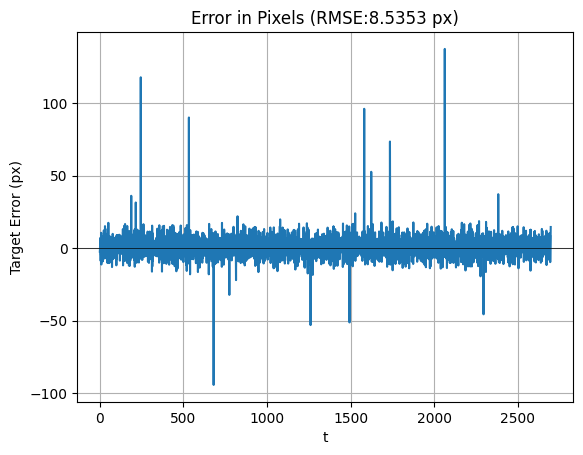

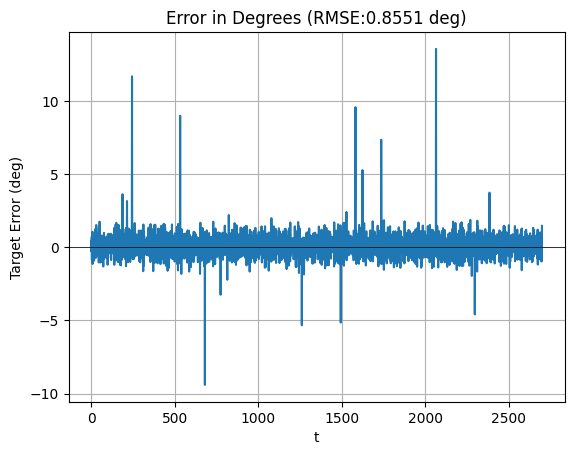

RMSE (px): 8.535321492932079
RMSE (deg): 0.8550699516893975


In [20]:
# Pan Policy

# Calculation of Error (Px)

%matplotlib inline

new_delta_x_arr = np.array(data["new_delta_x"][1:])
rmse_px = math.sqrt(np.sum(new_delta_x_arr**2)/len(new_delta_x_arr))
plt.plot(new_delta_x_arr)
plt.axhline(y=0, color='k', linewidth=0.5)
plt.xlabel('t')
plt.ylabel('Target Error (px)')
plt.grid()
plt.title("Error in Pixels (RMSE:%.4f px)" % (rmse_px))
plt.show()


# Calculation of Error (Deg)

err_target_deg = np.array([px_to_deg_fx(x) for x in new_delta_x_arr])
rmse_deg = math.sqrt(np.sum(err_target_deg**2)/len(new_delta_x_arr))
plt.plot(err_target_deg)
plt.axhline(y=0, color='k', linewidth=0.5)
plt.xlabel('t')
plt.ylabel('Target Error (deg)')
plt.grid()
plt.title("Error in Degrees (RMSE:%.4f deg)" % (rmse_deg))
plt.show()

print("RMSE (px):", rmse_px)
print("RMSE (deg):", rmse_deg)

Text(0, 0.5, 'Frequency %')

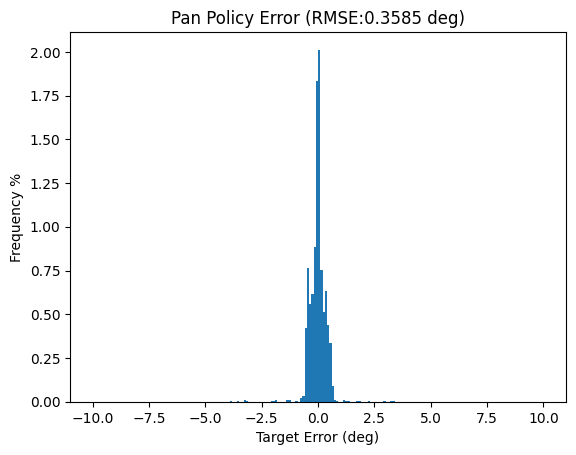

In [30]:
plt.title("Pan Policy Error (RMSE:%.4f deg)" % (rmse_deg))
plt.hist(err_target_deg, bins=200, range=(-10,10), density=True)
plt.xlabel('Target Error (deg)')
plt.ylabel('Frequency %')

Text(0, 0.5, 'φ_p (deg)')

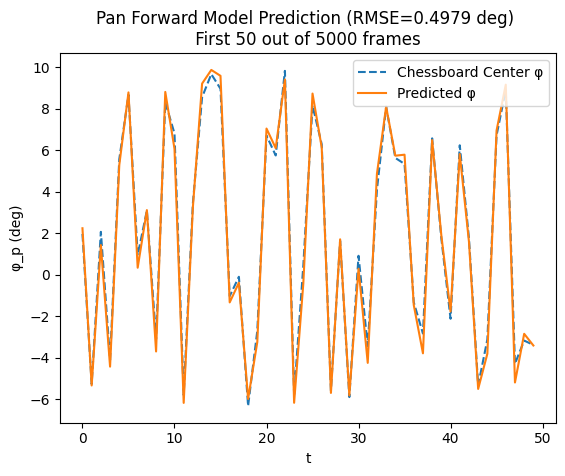

In [31]:
# Pan Forward Model

true_phi_p = [px_to_deg_fx(314.69441889-x[0]) for x in data["new_ctr_px"]]
pred_phi_p = data["new_model_phi_p"]
rmse_phi = mean_squared_error(true_phi_p, pred_phi_p, squared=False)
plt.plot(true_phi_p[:50], linestyle='--')
plt.plot(pred_phi_p[:50])
plt.title("Pan Forward Model Prediction (RMSE=%.4f deg) \n First 50 out of 5000 frames " % (rmse_phi))
plt.legend(["Chessboard Center φ", "Predicted φ"])
plt.xlabel("t")
plt.ylabel("φ_p (deg)")

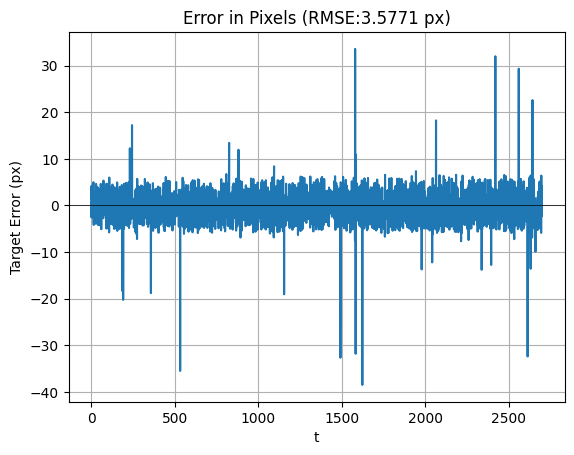

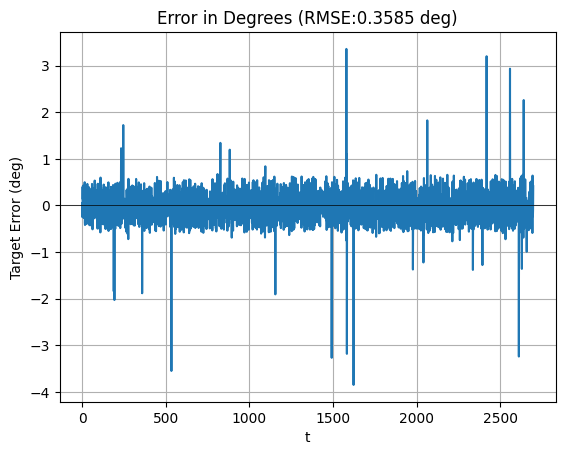

RMSE (px): 3.577073303665043
RMSE (deg): 0.35846683039516014


In [32]:
# Tilt Policy

# Calculation of Error (Px)

%matplotlib inline

new_delta_y_arr = np.array(data["new_delta_y"][1:])
rmse_px = math.sqrt(np.sum(new_delta_y_arr**2)/len(new_delta_y_arr))
plt.plot(new_delta_y_arr)
plt.axhline(y=0, color='k', linewidth=0.5)
plt.xlabel('t')
plt.ylabel('Target Error (px)')
plt.grid()
plt.title("Error in Pixels (RMSE:%.4f px)" % (rmse_px))
plt.show()


# Calculation of Error (Deg)

err_target_deg = np.array([px_to_deg_fy(x) for x in new_delta_y_arr])
rmse_deg = math.sqrt(np.sum(err_target_deg**2)/len(new_delta_y_arr))
plt.plot(err_target_deg)
plt.axhline(y=0, color='k', linewidth=0.5)
plt.xlabel('t')
plt.ylabel('Target Error (deg)')
plt.grid()
plt.title("Error in Degrees (RMSE:%.4f deg)" % (rmse_deg))
plt.show()

print("RMSE (px):", rmse_px)
print("RMSE (deg):", rmse_deg)

Text(0, 0.5, 'Frequency %')

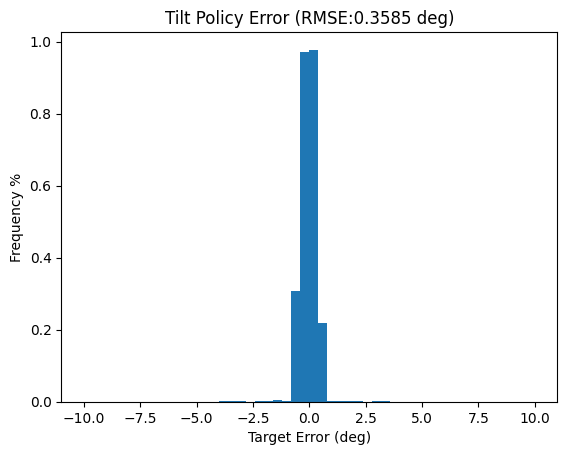

In [33]:
plt.title("Tilt Policy Error (RMSE:%.4f deg)" % (rmse_deg))
plt.hist(err_target_deg, bins=50, range=(-10,10), density=True)
plt.xlabel('Target Error (deg)')
plt.ylabel('Frequency %')

Text(0, 0.5, 'φ_t (deg)')

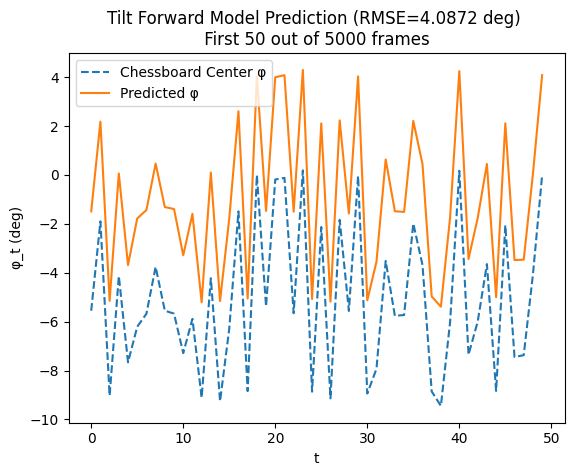

In [34]:
# Tilt Forward Model

true_phi_t = [px_to_deg_fx(x[1]-201.68845842) for x in data["new_ctr_px"]]
pred_phi_t = data["new_model_phi_t"]
rmse_phi = mean_squared_error(true_phi_t, pred_phi_t, squared=False)
plt.plot(true_phi_t[:50], linestyle='--')
plt.plot(pred_phi_t[:50])
plt.title("Tilt Forward Model Prediction (RMSE=%.4f deg) \n First 50 out of 5000 frames " % (rmse_phi))
plt.legend(["Chessboard Center φ", "Predicted φ"])
plt.xlabel("t")
plt.ylabel("φ_t (deg)")

# Saving the Data

In [19]:
data_list.append(data)
pickle_data["data"] = data_list
data_filepath = save_pickle_data(pickle_data, camera="left", name="1D-BASELINE_EXP30_NoRandPanTiltPolicy")

Data saved in: C:\dev\robot_control\const_results\20230603_051031_740295_left_1D-BASELINE_EXP30_NoRandPanTiltPolicy.pickle


## Playing the Video

In [ ]:
%matplotlib inline

plt.imshow(data["prev_disp_img"][0])
plt.show()
plt.imshow(data["new_disp_img"][0])
plt.show()

In [ ]:
# Input

num_frames = 50
# num_frames = len(data["prev_disp_img"])

In [ ]:
%matplotlib qt

plt.figure()
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.imshow(data["prev_disp_img"][0])
plt.pause(2)
for i in range(num_frames):
    plt.clf()
    plt.imshow(data["prev_disp_img"][i])
    plt.pause(0.5)
    plt.clf()
    plt.imshow(data["new_disp_img"][i])
    plt.pause(0.5)
    plt.draw()